In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")
print(df.shape)
df.head()


(1190, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [2]:
# Assume last column is target if not sure
target_col = df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

print("Target column:", target_col)
print("Target value counts:\n", y.value_counts())


Target column: target
Target value counts:
 target
1    629
0    561
Name: count, dtype: int64


In [3]:
# strip leading/trailing spaces from column names (keep original wording)
df.columns = [c.strip() for c in df.columns]

# for object columns: strip whitespace; make obvious "missing" tokens into NaN
obj_cols = df.select_dtypes(include=["object"]).columns
for c in obj_cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.strip()
        .replace({"": np.nan, "na": np.nan, "n/a": np.nan, "null": np.nan, "?": np.nan, "none": np.nan, "nan": np.nan})
    )

print("after name/text tidy:", df.shape)


after name/text tidy: (1190, 12)


In [4]:
# remove exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
print(f"removed duplicate rows: {before - df.shape[0]}")

# remove duplicate columns (identical across all rows)
dupe_cols = df.T.duplicated()
if dupe_cols.any():
    cols_to_drop = df.columns[dupe_cols].tolist()
    df = df.loc[:, ~dupe_cols]
    print("dropped duplicate columns:", cols_to_drop)
else:
    print("no duplicate columns found")


removed duplicate rows: 272
no duplicate columns found


In [5]:
# try to coerce any object column that looks numeric into numeric dtype
for c in obj_cols:
    coerced = pd.to_numeric(df[c], errors="ignore")
    if not isinstance(coerced.dtype, pd.StringDtype) and str(coerced.dtype) != "object":
        df[c] = coerced

print("dtypes after coercion:")
print(df.dtypes)


dtypes after coercion:
age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object


In [6]:
MISSING_COL_THRESHOLD = 0.40  # drop columns with >40% missing
missing_frac = df.isna().mean()
cols_high_missing = missing_frac[missing_frac > MISSING_COL_THRESHOLD].index.tolist()
if cols_high_missing:
    df = df.drop(columns=cols_high_missing)
    print("dropped high-missing columns:", cols_high_missing)
else:
    print("no high-missing columns to drop")

print("shape after drop:", df.shape)


no high-missing columns to drop
shape after drop: (918, 12)


In [7]:
import numpy as np
# OPTIONAL: winsorize (cap) numeric outliers using IQR rule
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        continue
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df[c] = df[c].clip(lower=low, upper=high)

print("outlier capping done (IQR) on numeric cols.")


outlier capping done (IQR) on numeric cols.


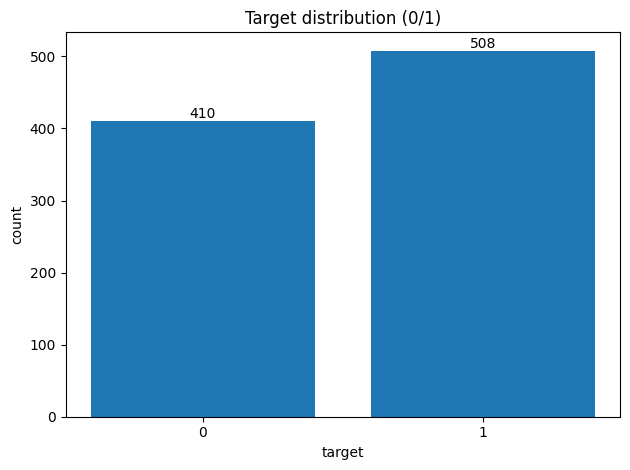

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- config
TARGET = "target"
assert TARGET in df.columns, "Please set TARGET to your target column name."

# --- counts
counts = df[TARGET].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target distribution (0/1)")
plt.xlabel(TARGET)
plt.ylabel("count")
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout()
plt.show()


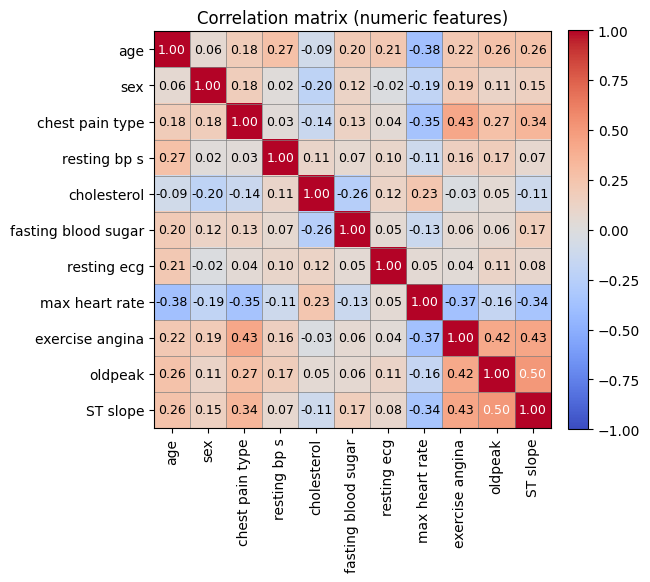

In [9]:
import numpy as np
import matplotlib.pyplot as plt

TARGET = "target"  # change if your target column is different

# Pick numeric columns only (exclude target)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_cols:
    num_cols.remove(TARGET)

if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)

    # Autosize so labels/values are readable
    n = len(num_cols)
    fig_w = max(6, 0.6 * n)
    fig_h = max(5, 0.6 * n)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")

    ax.set_title("Correlation matrix (numeric features)")
    ax.set_xticks(np.arange(n)); ax.set_yticks(np.arange(n))
    ax.set_xticklabels(num_cols, rotation=90); ax.set_yticklabels(num_cols)

    # optional gridlines
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", color="gray", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # annotate each cell with value
    for i in range(n):
        for j in range(n):
            val = corr.values[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    color=("white" if abs(val) > 0.5 else "black"), fontsize=9)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xlim(-0.5, n - 0.5); ax.set_ylim(n - 0.5, -0.5)  # keep orientation
    plt.tight_layout()
    plt.show()


else:
    print("Not enough numeric features for a correlation heatmap.")


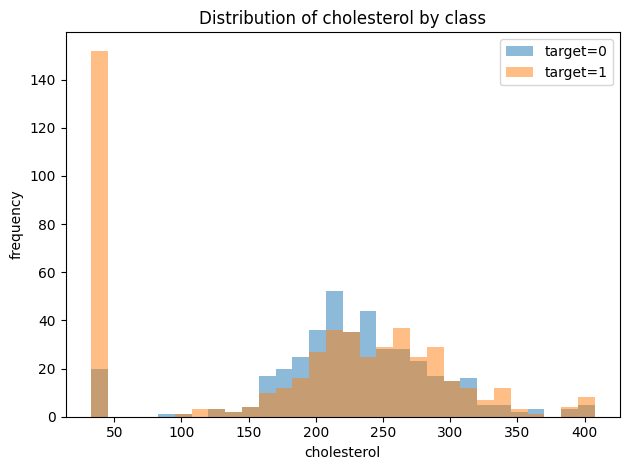

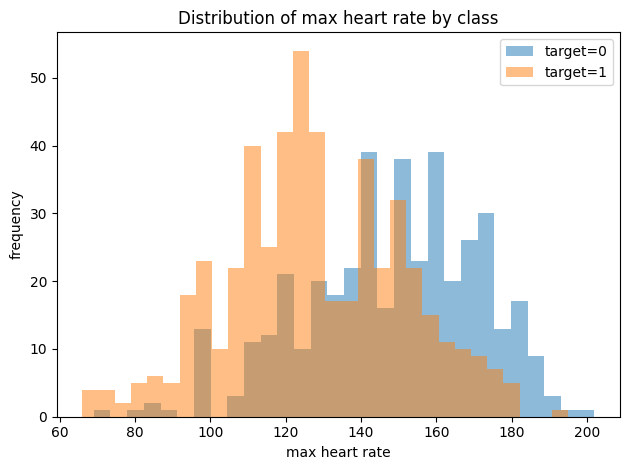

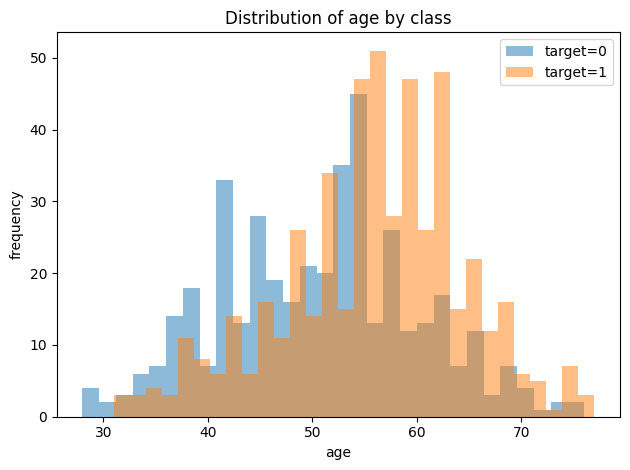

In [10]:
# Choose up to 3 continuous features (many unique values, not binary-like)
cont_cols = []
for c in df.select_dtypes(include=[np.number]).columns:
    if c == TARGET:
        continue
    u = df[c].nunique(dropna=True)
    if u > 20:  # treat as continuous
        cont_cols.append(c)

# Rank by absolute difference in means between classes (simple separability proxy)
if len(cont_cols) == 0:
    print("No continuous features found for class-separated distributions.")
else:
    diffs = []
    for c in cont_cols:
        m1 = df.loc[df[TARGET] == 1, c].mean()
        m0 = df.loc[df[TARGET] == 0, c].mean()
        diffs.append((abs(m1 - m0), c))
    diffs.sort(reverse=True)
    top_feats = [c for _, c in diffs[:3]]

    for c in top_feats:
        plt.figure()
        # hist overlay
        df.loc[df[TARGET] == 0, c].dropna().plot(kind="hist", bins=30, alpha=0.5, label="target=0")
        df.loc[df[TARGET] == 1, c].dropna().plot(kind="hist", bins=30, alpha=0.5, label="target=1")
        plt.title(f"Distribution of {c} by class")
        plt.xlabel(c)
        plt.ylabel("frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [11]:
# detect likely target; fallback to last column
lower_map = {c.lower(): c for c in df.columns}
for guess in ["target", "num", "class", "diagnosis", "heart_disease"]:
    if guess in lower_map:
        target_col = lower_map[guess]
        break
else:
    target_col = df.columns[-1]  # fallback

# convert target to binary 0/1 as a simple rule
def to_binary(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        uniq = pd.unique(series.dropna())
        if set(np.sort(uniq)) <= {0, 1}:
            return series.astype(int)
        return (series.astype(float) > 0).astype(int)
    s = series.astype(str).str.strip().str.lower()
    positive = {"1","true","yes","disease","present","pos","positive"}
    return s.isin(positive).astype(int)

if target_col != "target":
    df = df.rename(columns={target_col: "target"})
    target_col = "target"

y = to_binary(df[target_col])
X = df.drop(columns=[target_col])

print("target column:", target_col, "| positive rate:", round(float(y.mean()), 4))
print("X shape:", X.shape, " y shape:", y.shape)


target column: target | positive rate: 0.5534
X shape: (918, 11)  y shape: (918,)


In [12]:
# fill numeric with median; categorical with most frequent
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_clean = X.copy()

# numeric median fill
for c in num_cols:
    X_clean[c] = X_clean[c].fillna(X_clean[c].median())

# categorical mode fill
for c in cat_cols:
    if X_clean[c].isna().any():
        mode_val = X_clean[c].mode(dropna=True)
        mode_val = mode_val.iloc[0] if not mode_val.empty else "missing"
        X_clean[c] = X_clean[c].fillna(mode_val)

print("missing values remaining (per column):")
print(X_clean.isna().sum()[X_clean.isna().sum() > 0])


missing values remaining (per column):
Series([], dtype: int64)


In [13]:
# === Fix for NameError: X_train is not defined ===
# Creates: X_train, X_test, y_train, y_test (with a robust fallback)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# If X and y already exist, use them. Otherwise, derive from df.
if 'X' in globals() and 'y' in globals():
    _X, _y = X.copy(), y.copy()
else:
    assert 'df' in globals(), "DataFrame 'df' not found. Load your data into 'df' first."
    TARGET = 'target' if 'target' in df.columns else df.columns[-1]
    _y = df[TARGET]
    _X = df.drop(columns=[TARGET])

    # Make y binary if needed
    if pd.api.types.is_numeric_dtype(_y):
        _y = (_y.astype(float) > 0).astype(int)
    else:
        s = _y.astype(str).str.strip().str.lower()
        _y = s.isin({'1','true','yes','disease','present','pos','positive'}).astype(int)

# Drop rows where y is NaN (just in case)
mask = _y.notna()
_X, _y = _X.loc[mask], _y.loc[mask]

# Train/test split (try stratified; fall back if classes are degenerate)
try:
    X_train, X_test, y_train, y_test = train_test_split(
        _X, _y, test_size=0.20, stratify=_y, random_state=RANDOM_STATE
    )
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        _X, _y, test_size=0.20, random_state=RANDOM_STATE
    )

print("Created splits:")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train positive rate:", round(float(y_train.mean()), 4),
      "| y_test positive rate:", round(float(y_test.mean()), 4))


Created splits:
X_train: (734, 11) | X_test: (184, 11)
y_train positive rate: 0.5531 | y_test positive rate: 0.5543


In [14]:
# ===== Continue: preprocessing after train/test split =====
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1) Identify column types on TRAIN ONLY
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# 2) Simple imputation (median for numeric, mode for categorical) — in-place on copies
X_train_clean = X_train.copy()
X_test_clean  = X_test.copy()

# numeric -> median (fit on train)
for c in num_cols:
    median_val = X_train_clean[c].median()
    X_train_clean[c] = X_train_clean[c].fillna(median_val)
    X_test_clean[c]  = X_test_clean[c].fillna(median_val)

# categorical -> mode (fit on train)
for c in cat_cols:
    mode_vals = X_train_clean[c].mode(dropna=True)
    fill_val = mode_vals.iloc[0] if not mode_vals.empty else "missing"
    X_train_clean[c] = X_train_clean[c].fillna(fill_val)
    X_test_clean[c]  = X_test_clean[c].fillna(fill_val)

# 3) One-hot encode categoricals (fit on train; align test columns)
X_train_enc = pd.get_dummies(X_train_clean, columns=cat_cols, dummy_na=False)
X_test_enc  = pd.get_dummies(X_test_clean,  columns=cat_cols, dummy_na=False)

# Align columns so test has same set as train
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# 4) Scale ONLY the original numeric columns (dummies are already 0/1)
num_cols_after = [c for c in X_train_enc.columns if c in num_cols]
scaler = StandardScaler()
X_train_enc[num_cols_after] = scaler.fit_transform(X_train_enc[num_cols_after])
X_test_enc[num_cols_after]  = scaler.transform(X_test_enc[num_cols_after])

# 5) Ready-to-model matrices
X_train_ready = X_train_enc
X_test_ready  = X_test_enc

print("Train ready shape:", X_train_ready.shape, "| Test ready shape:", X_test_ready.shape)
print("Sample of processed train features:")
print(X_train_ready.head())



Numeric cols: ['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']
Categorical cols: []
Train ready shape: (734, 11) | Test ready shape: (184, 11)
Sample of processed train features:
          age      sex  chest pain type  resting bp s  cholesterol  \
486  0.970012  0.51740        -1.454009      0.383646     0.095222   
487  0.122028  0.51740        -1.454009     -1.321927     0.063649   
117  0.546020 -1.93274         0.814307     -0.145670     1.368654   
362 -0.725956  0.51740         0.814307      1.618715    -1.845184   
297 -0.407962  0.51740         0.814307      0.736523    -1.845184   

     fasting blood sugar  resting ecg  max heart rate  exercise angina  \
486             1.835497     0.512708       -0.325432         1.202775   
487             1.835497     0.512708        1.691632        -0.831411   
117             1.835497     0.512708       -0.247852         1.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Train
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_ready, y_train)

# Predict
rf_proba = rf.predict_proba(X_test_ready)[:, 1]
rf_pred = (rf_proba >= 0.5).astype(int)

# Metrics
print("=== Random Forest ===")
print("Accuracy :", round(accuracy_score(y_test, rf_pred), 4))
print("Precision:", round(precision_score(y_test, rf_pred, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, rf_pred, zero_division=0), 4))
print("F1       :", round(f1_score(y_test, rf_pred, zero_division=0), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, rf_proba), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred, digits=3))


=== Random Forest ===
Accuracy : 0.8859
Precision: 0.8785
Recall   : 0.9216
F1       : 0.8995
ROC AUC  : 0.9319

Confusion Matrix:
 [[69 13]
 [ 8 94]]

Classification Report:
               precision    recall  f1-score   support

           0      0.896     0.841     0.868        82
           1      0.879     0.922     0.900       102

    accuracy                          0.886       184
   macro avg      0.887     0.882     0.884       184
weighted avg      0.886     0.886     0.885       184



In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Train
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss",
    tree_method="hist"
)
xgb.fit(X_train_ready, y_train)

# Predict
xgb_proba = xgb.predict_proba(X_test_ready)[:, 1]
xgb_pred = (xgb_proba >= 0.5).astype(int)

# Metrics
print("=== XGBoost ===")
print("Accuracy :", round(accuracy_score(y_test, xgb_pred), 4))
print("Precision:", round(precision_score(y_test, xgb_pred, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, xgb_pred, zero_division=0), 4))
print("F1       :", round(f1_score(y_test, xgb_pred, zero_division=0), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, xgb_proba), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred, digits=3))



=== XGBoost ===
Accuracy : 0.8696
Precision: 0.89
Recall   : 0.8725
F1       : 0.8812
ROC AUC  : 0.9266

Confusion Matrix:
 [[71 11]
 [13 89]]

Classification Report:
               precision    recall  f1-score   support

           0      0.845     0.866     0.855        82
           1      0.890     0.873     0.881       102

    accuracy                          0.870       184
   macro avg      0.868     0.869     0.868       184
weighted avg      0.870     0.870     0.870       184



In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Train (works best with scaled inputs — which you have)
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)
mlp.fit(X_train_ready, y_train)

# Predict
mlp_proba = mlp.predict_proba(X_test_ready)[:, 1]
mlp_pred = (mlp_proba >= 0.5).astype(int)

# Metrics
print("=== ANN (MLP) ===")
print("Accuracy :", round(accuracy_score(y_test, mlp_pred), 4))
print("Precision:", round(precision_score(y_test, mlp_pred, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, mlp_pred, zero_division=0), 4))
print("F1       :", round(f1_score(y_test, mlp_pred, zero_division=0), 4))
print("ROC AUC  :", round(roc_auc_score(y_test, mlp_proba), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, mlp_pred))
print("\nClassification Report:\n", classification_report(y_test, mlp_pred, digits=3))


=== ANN (MLP) ===
Accuracy : 0.8587
Precision: 0.8585
Recall   : 0.8922
F1       : 0.875
ROC AUC  : 0.9107

Confusion Matrix:
 [[67 15]
 [11 91]]

Classification Report:
               precision    recall  f1-score   support

           0      0.859     0.817     0.838        82
           1      0.858     0.892     0.875       102

    accuracy                          0.859       184
   macro avg      0.859     0.855     0.856       184
weighted avg      0.859     0.859     0.858       184



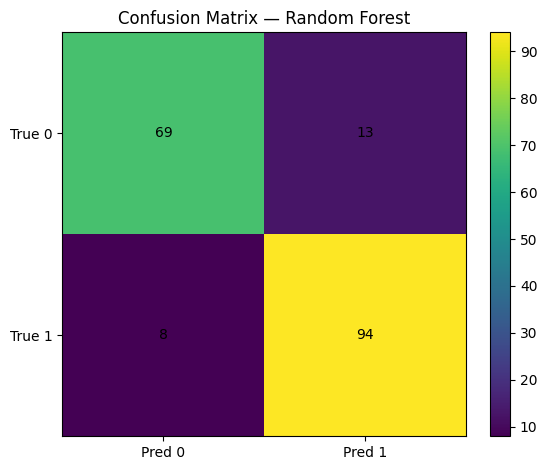

Random Forest CM:
[[69 13]
 [ 8 94]]



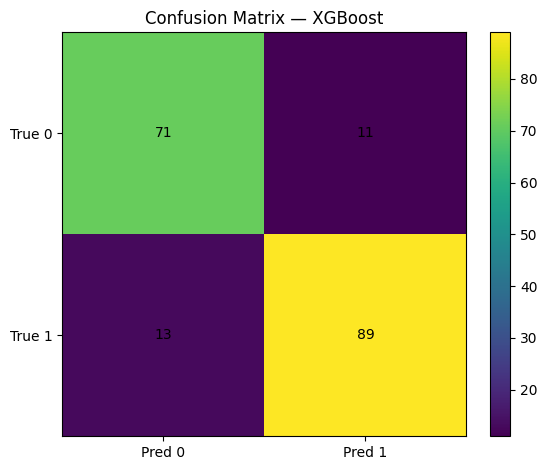

XGBoost CM:
[[71 11]
 [13 89]]



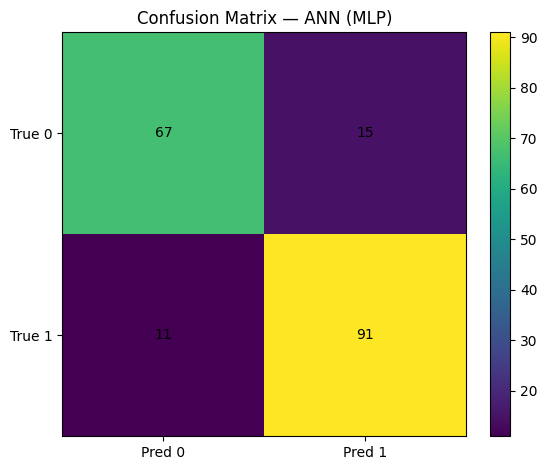

ANN (MLP) CM:
[[67 15]
 [11 91]]



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

models = [("Random Forest", rf), ("XGBoost", xgb), ("ANN (MLP)", mlp)]

def plot_cm(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, aspect="equal")
    ax.set_title(f"Confusion Matrix — {name}")
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    print(f"{name} CM:\n{cm}\n")

for name, clf in models:
    proba = clf.predict_proba(X_test_ready)[:, 1]
    pred = (proba >= 0.5).astype(int)
    plot_cm(name, y_test, pred)


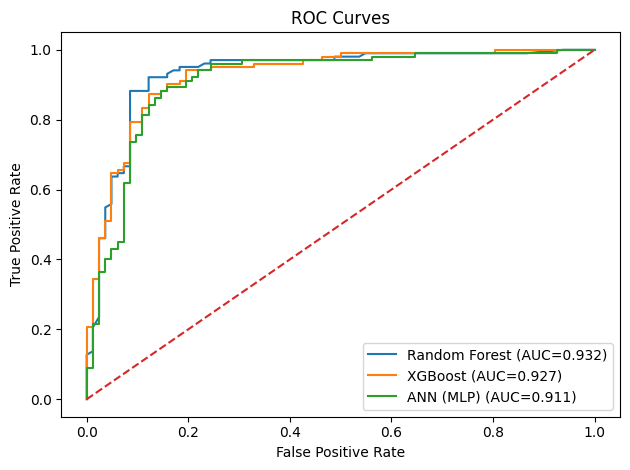

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

models = [("Random Forest", rf), ("XGBoost", xgb), ("ANN (MLP)", mlp)]

plt.figure()
for name, clf in models:
    proba = clf.predict_proba(X_test_ready)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_param_dist = {
    "n_estimators": [200, 300, 400, 600, 800],
    "max_depth": [None, 4, 6, 8, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, None],
    "bootstrap": [True, False],
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X_train_ready, y_train)
rf_best = rf_search.best_estimator_

rf_proba = rf_best.predict_proba(X_test_ready)[:, 1]
rf_pred  = (rf_proba >= 0.5).astype(int)

print("Best RF params:", rf_search.best_params_)
print("Best CV ROC AUC:", round(rf_search.best_score_, 4))
print("Test ROC AUC  :", round(roc_auc_score(y_test, rf_proba), 4))
print("Accuracy      :", round(accuracy_score(y_test, rf_pred), 4))
print("Precision     :", round(precision_score(y_test, rf_pred, zero_division=0), 4))
print("Recall        :", round(recall_score(y_test, rf_pred, zero_division=0), 4))
print("F1            :", round(f1_score(y_test, rf_pred, zero_division=0), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification report:\n", classification_report(y_test, rf_pred, digits=3))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}
Best CV ROC AUC: 0.933
Test ROC AUC  : 0.9314
Accuracy      : 0.8913
Precision     : 0.8796
Recall        : 0.9314
F1            : 0.9048

Confusion matrix:
 [[69 13]
 [ 7 95]]

Classification report:
               precision    recall  f1-score   support

           0      0.908     0.841     0.873        82
           1      0.880     0.931     0.905       102

    accuracy                          0.891       184
   macro avg      0.894     0.886     0.889       184
weighted avg      0.892     0.891     0.891       184



In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb_param_dist = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1],
    "reg_lambda": [0.0, 1.0, 2.0, 5.0],
    "min_child_weight": [1, 3, 5, 7]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
xgb_search.fit(X_train_ready, y_train)
xgb_best = xgb_search.best_estimator_

xgb_proba = xgb_best.predict_proba(X_test_ready)[:, 1]
xgb_pred  = (xgb_proba >= 0.5).astype(int)

print("Best XGB params:", xgb_search.best_params_)
print("Best CV ROC AUC:", round(xgb_search.best_score_, 4))
print("Test ROC AUC  :", round(roc_auc_score(y_test, xgb_proba), 4))
print("Accuracy      :", round(accuracy_score(y_test, xgb_pred), 4))
print("Precision     :", round(precision_score(y_test, xgb_pred, zero_division=0), 4))
print("Recall        :", round(recall_score(y_test, xgb_pred, zero_division=0), 4))
print("F1            :", round(f1_score(y_test, xgb_pred, zero_division=0), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, xgb_pred))
print("\nClassification report:\n", classification_report(y_test, xgb_pred, digits=3))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best XGB params: {'subsample': 0.8, 'reg_lambda': 2.0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV ROC AUC: 0.9355
Test ROC AUC  : 0.9326
Accuracy      : 0.9022
Precision     : 0.9038
Recall        : 0.9216
F1            : 0.9126

Confusion matrix:
 [[72 10]
 [ 8 94]]

Classification report:
               precision    recall  f1-score   support

           0      0.900     0.878     0.889        82
           1      0.904     0.922     0.913       102

    accuracy                          0.902       184
   macro avg      0.902     0.900     0.901       184
weighted avg      0.902     0.902     0.902       184

